<a href="https://colab.research.google.com/github/yoineko/skillfactory-module6/blob/master/baseline_keras_xception_car_class_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Это пример решения задачи с техники управления Learning Rate. Подгрузка модуля CLR c https://github.com/bckenstler/CLR
# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть Xception и дообучить под нашу задачу. 
По ходу решения мы будем давать вам рекомендации, которые помогут улучшить качество модели. 


Удачи и Поехали!

In [41]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=8447caa04c43f62fea012156e2f1ca5f4423f7f4e55cb0f413861e1fa8a102c0
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 24.5 GB  | Proc size: 3.1 GB
GPU RAM Free: 757MB | Used: 15523MB | Util  95% | Total 16280MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DIR = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [42]:
!nvidia-smi

Mon Aug 17 11:57:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    43W / 250W |  15523MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir(DIR+ "input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['sample-submission.csv', 'test.zip', 'train.csv', 'train.zip', 'train.gsheet', 'sample-submission.gsheet']
Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [ ]:
!pip freeze > requirements.txt

# Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 25 #5  # эпох на обучение
BATCH_SIZE           = 32 #64 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 350#224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# DATA_PATH = '../input/'
# PATH = "../working/car/" # рабочая директория
DATA_PATH =  DIR + 'input/'
PATH = DIR + "working/car/" # рабочая директория
ver = 27

In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости
#os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [ ]:
# чистит сессию в Keras и TF
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

# EDA / Анализ данных

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
#train_df.info()

In [ ]:
#train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

In [ ]:
# print('Распаковываем картинки')
# # Will unzip the files so that you can see them..
# for data_zip in ['train.zip', 'test.zip']:
#     with zipfile.ZipFile("../input/"+data_zip,"r") as z:
#         z.extractall(PATH)
        
# print(os.listdir(PATH))

In [ ]:
# print('Пример картинок (random sample)')
# plt.figure(figsize=(12,8))

# random_image = train_df.sample(n=9)
# random_image_paths = random_image['Id'].values
# random_image_cat = random_image['Category'].values

# for index, path in enumerate(random_image_paths):
#     im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
#     plt.subplot(3,3, index+1)
#     plt.imshow(im)
#     plt.title('Class: '+str(random_image_cat[index]))
#     plt.axis('off')
# plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

In [ ]:
# image = PIL.Image.open(PATH+'/train/0/100380.jpg')
# imgplot = plt.imshow(image)
# plt.show()
# image.size

### Уже догадываетесь, что означают классы?

# Подготовка данных

### Аугментация данных

In [ ]:
# # Вы помните, что аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.
# # Чтобы лучше понять работу параметров, попробуйте их изменить. К какому результату это приведет?
# # Официальная документация: https://keras.io/preprocessing/image/

# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     validation_split=VAL_SPLIT, # set validation split
#     horizontal_flip=False)

# test_datagen = ImageDataGenerator(rescale=1. / 255)

# #Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.3,
    fill_mode='reflect'
    )

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.3,
    fill_mode='reflect'
    )

### Генерация данных

In [ ]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

#test_sub_generator = test_datagen.flow_from_dataframe( 
test_sub_generator = train_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
# чистите сессию иначе кончится память!
#s = reset_tf_session()
#K.clear_session()


# Построение модели

### Загружаем предобученную сеть Xception:

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83689472/83683744 [==============================] - 2s 0us/step


In [ ]:
#base_model.summary()
# Рекомендация: Попробуйте и другие архитектуры сетей

In [ ]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * tf.math.exp(-0.1)


def get_triangular_lr(iteration, stepsize, base_lr, max_lr):
    """Given the inputs, calculates the lr that should be applicable for this iteration"""
    cycle = np.floor(1 + iteration/(2  * stepsize))
    x = np.abs(iteration/stepsize - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
    return lr

# Demo of how the LR varies with iterations
num_iterations = len(train_generator) * EPOCHS
stepsize = len(train_generator) / BATCH_SIZE * 2
base_lr = LR      #0.0001
max_lr =  LR * 10 #0.001
lr_trend = list()

for iteration in range(num_iterations):
    lr = get_triangular_lr(iteration, stepsize, base_lr, max_lr)
    # Update your optimizer to use this learning rate in this iteration
    lr_trend.append(lr)     

lr_trend = np.array(lr_trend)    

In [ ]:
start_lr = 1e-5
end_lr = 1e-1

In [ ]:
# # Устанавливаем новую "голову" (head)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# #x = Dropout(0.25)(x)
# x = BatchNormalization()(x)
# # let's add a fully-connected layer
# x = Dense(256, activation='relu')(x)
# #x = Dropout(0.25)(x)
# x = BatchNormalization()(x)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# #x = Dropout(0.25)(x)
# # and a logistic layer -- let's say we have 10 classes
# predictions = Dense(CLASS_NUM, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)
# #model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])
# model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=start_lr), metrics=["accuracy"])

In [ ]:
# Устанавливаем новую "голову" (head)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
#model.summary()
# Рекомендация: Попробуйте добавить Batch Normalization

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:
#ver = 10
checkpoint = ModelCheckpoint(DIR+ f'best_model/best_model{ver}.hdf5' , monitor = 'val_accuracy' , verbose = 1  , save_best_only = True, mode = 'max')
earlystop = EarlyStopping(patience=5, monitor='val_loss'),
callbacks_list = [checkpoint] #, learningrate]

# Рекомендация 1. Добавьте другие функции из https://keras.io/callbacks/
# Рекомендация 2. Используйте разные техники управления Learning Rate
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng)
# http://teleported.in/posts/cyclic-learning-rate/ (eng)

In [ ]:
from CLR.clr_callback import CyclicLR
#from LRF.lr_finder import LRFinder

In [ ]:
# # Define LR finder callback

# lr_finder = LRFinder(min_lr=start_lr, max_lr=end_lr)

# # Perform LR finder
# #model.fit(train_generator, target_train, batch_size=BATCH_SIZE, callbacks=[lr_finder], epochs=EPOCHS)
# model.fit(
#         train_generator,
#         steps_per_epoch = len(train_generator),
#         validation_data = test_generator, 
#         validation_steps = len(test_generator),
#         epochs = EPOCHS,
#         callbacks = [lr_finder]
# )


In [ ]:
# Set CLR options
clr_step_size = int(4 * (len(train_generator)/BATCH_SIZE))
base_lr = 1e-5 #LR
max_lr = 0.006 #LR *100 # 1e-2
mode='triangular'

In [ ]:

#learningrate = LearningRateScheduler(scheduler)
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)
callbacks_list = [checkpoint, clr, earlystop]

Обучаем:

In [30]:
%%time
# ver = 23
# EPOCHS = 10
#history = model.fit_generator(
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

# Рекомендация: попробуйте применить transfer learning с fine-tuning

Epoch 1/25
414/414 [==============================] - ETA: 0s - loss: 1.6331 - accuracy: 0.3627
Epoch 00001: val_accuracy improved from -inf to 0.30485, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model27.hdf5
414/414 [==============================] - 4309s 10s/step - loss: 1.6331 - accuracy: 0.3627 - val_loss: 3.9264 - val_accuracy: 0.3049
Epoch 2/25
414/414 [==============================] - ETA: 0s - loss: 1.1190 - accuracy: 0.5626
Epoch 00002: val_accuracy improved from 0.30485 to 0.51997, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model27.hdf5
414/414 [==============================] - 504s 1s/step - loss: 1.1190 - accuracy: 0.5626 - val_loss: 2.5051 - val_accuracy: 0.5200
Epoch 3/25
414/414 [==============================] - ETA: 0s - loss: 0.8750 - accuracy: 0.6625
Epoch 00003: val_accuracy improved from 0.51997 to 0.70975, saving model to /content/drive/My Drive/Colab Notebooks

```
Epoch 00001: saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model.hdf5
207/207 [==============================] - 5186s 25s/step - loss: 0.8646 - accuracy: 0.7010 - val_loss: 0.3117 - val_accuracy: 0.8918
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9271
Epoch 00002: saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model.hdf5
207/207 [==============================] - 305s 1s/step - loss: 0.2012 - accuracy: 0.9271 - val_loss: 0.2388 - val_accuracy: 0.9060
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.9588
Epoch 00003: saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model.hdf5
207/207 [==============================] - 296s 1s/step - loss: 0.1086 - accuracy: 0.9588 - val_loss: 0.2532 - val_accuracy: 0.9150
Epoch 4/5
207/207 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9766
Epoch 00004: saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model.hdf5
207/207 [==============================] - 287s 1s/step - loss: 0.0700 - accuracy: 0.9766 - val_loss: 0.2150 - val_accuracy: 0.9373
Epoch 5/5
207/207 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9831
Epoch 00005: saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model.hdf5
207/207 [==============================] - 287s 1s/step - loss: 0.0517 - accuracy: 0.9831 - val_loss: 0.2805 - val_accuracy: 0.9249
CPU times: user 29min 1s, sys: 4min 4s, total: 33min 5s
Wall time: 1h 46min 55s
```

In [31]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save(DIR + f'working/model_last{ver}.hdf5')
model.load_weights(DIR + f'best_model/best_model{ver}.hdf5')

In [32]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
73/73 [==============================] - 72s 987ms/step - loss: 0.5159 - accuracy: 0.8094
Accuracy: 80.94%


В Итоге точность нашей модели составила 93%. 
Учитывая что классов 10 - это Очень хороший результат!     
Посмотрим графики обучения:

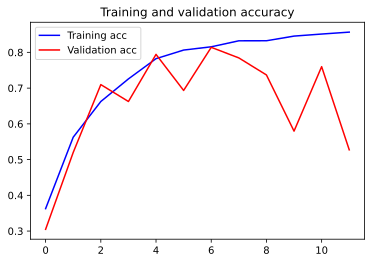

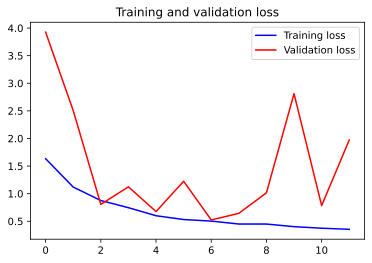

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Предсказание на тестовых данных

In [34]:
test_sub_generator.samples

6675

In [35]:
# test_sub_generator.reset()
# #predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
# predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
# predictions = np.argmax(predictions, axis=-1) #multiple categories
# label_map = (train_generator.class_indices)
# label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
# predictions = [label_map[k] for k in predictions]

In [36]:
from tqdm import tqdm

test_sub_generator.reset()
tta_steps = 10
l_predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    l_predictions.append(preds)

pred = np.mean(l_predictions, axis=0)


predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

  0%|          | 0/10 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.predict, which supports generators.
209/209 [==============================] - 1936s 9s/step


 10%|█         | 1/10 [32:27<4:52:05, 1947.23s/it]

209/209 [==============================] - 204s 978ms/step


 20%|██        | 2/10 [35:53<3:09:59, 1424.98s/it]

209/209 [==============================] - 204s 978ms/step


 30%|███       | 3/10 [39:20<2:03:35, 1059.42s/it]

209/209 [==============================] - 204s 976ms/step


 40%|████      | 4/10 [42:46<1:20:20, 803.38s/it] 

209/209 [==============================] - 204s 978ms/step


 50%|█████     | 5/10 [46:12<52:01, 624.27s/it]  

209/209 [==============================] - 205s 980ms/step


 60%|██████    | 6/10 [49:39<33:16, 499.01s/it]

209/209 [==============================] - 204s 978ms/step


 70%|███████   | 7/10 [53:05<20:33, 411.22s/it]

209/209 [==============================] - 205s 979ms/step


 80%|████████  | 8/10 [56:32<11:39, 349.84s/it]

209/209 [==============================] - 204s 976ms/step


 90%|█████████ | 9/10 [59:58<05:06, 306.71s/it]

209/209 [==============================] - 204s 977ms/step


100%|██████████| 10/10 [1:03:24<00:00, 380.43s/it]


In [37]:
#ver = 3
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(DIR + f'submission{ver}.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Save submit


In [38]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


In [39]:
# Clean PATH
# import shutil
# shutil.rmtree(PATH)

## Интересно, к какому классу модель отнесет вот эти автомобили?

# Что можно сделать, чтобы улучшить результат:

* Примените transfer learning с fine-tuning
* Настройте LR, optimizer, loss
* Подберите другие переменные (размер картинки, батч и т.д.)
* Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet  
* 
* Добавьте Batch Normalization и поэкспериментируйте с архитектурой “головы”
* Примените другие функции callback Keras https://keras.io/callbacks/ 
* Добавьте TTA (Test Time Augmentation)
* Дополнительно*: Используйте разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: Добавьте более продвинутые библиотеки аугментации изображений (например, Albumentations )

### Удачи в соревновании!

In [ ]:
input_shape_t = (2, 2, 1, 3)
x_t = tf.random.normal(input_shape_t)
y_t = tf.keras.layers.GlobalAveragePooling2D()(x_t)
print(y_t.shape)
x_t,y_t